## Our Goals
1. Clean up the dataset, add NA values (as described in the document), remove any unusable features  
2. Investigate individual feature distributions and decide on scaling methods  
3. Perform feature selection, using MI and chi-square + multicollinearity to remove irrelevant or highly correlated features  
4. Explore dimensional reduction techniques  
5. Train baseline models, select the most useful model and preprocessing methods  
6. Tune model, create production-ready exports

## Credits 
Looked over these similiar projects  
1. https://www.kaggle.com/code/matthewmcnulty/bank-account-fraud#6.-Tree-Based-Machine-Learning-Algorithms-for-Fraud-Detection-of-Bank-Account-Applications 
2. https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
3. https://www.kaggle.com/code/gpreda/credit-card-fraud-detection-predictive-models


# Libraries

In [322]:
# Base libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

# Sklearn
import sklearn.decomposition as decomposition
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.manifold import TSNE
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.base import clone

# ML Models
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb


# Imbalanced Learn methods for samppling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as ImbPipeline

# extra scipy  
from scipy.stats import uniform, randint, loguniform, chi2_contingency

# for MCA 
import prince

set_config(transform_output="pandas")


# Basic Data Cleaning and Exploration

In [373]:
df.loc[df['fraud_bool'] == 1, :].head(1).to_dict(index=False, orient = 'tight')

{'columns': ['fraud_bool',
  'income',
  'name_email_similarity',
  'customer_age',
  'days_since_request',
  'intended_balcon_amount',
  'payment_type',
  'zip_count_4w',
  'velocity_6h',
  'velocity_24h',
  'velocity_4w',
  'bank_branch_count_8w',
  'date_of_birth_distinct_emails_4w',
  'employment_status',
  'credit_risk_score',
  'email_is_free',
  'housing_status',
  'phone_home_valid',
  'phone_mobile_valid',
  'has_other_cards',
  'proposed_credit_limit',
  'foreign_request',
  'source',
  'session_length_in_minutes',
  'device_os',
  'keep_alive_session',
  'device_distinct_emails_8w',
  'month_sin',
  'month_cos'],
 'data': [[1,
   0.10000000149011612,
   0.5249947309494019,
   20.0,
   0.0014186592306941748,
   -0.7624531388282776,
   'AC',
   2371.0,
   6869.3974609375,
   6826.61376953125,
   5483.5908203125,
   0.0,
   6.0,
   'CA',
   55.0,
   0,
   'BE',
   0,
   1,
   0,
   200.0,
   0,
   0,
   12.901134490966797,
   'other',
   1,
   1.0,
   0.0,
   1.0]],
 'column_na

In [2]:
df_raw = pd.read_csv('data/neurips/Base.csv')
df = df_raw.copy()
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


Significant class imbalance will need to have a sampling discussion eventually

In [3]:
print("Num fraud: ", df['fraud_bool'].sum() / len(df))
print("Num non fraud: ",( len(df) - df['fraud_bool'].sum())/len(df))

Num fraud:  0.011029
Num non fraud:  0.988971


First quick check to see if any columns contain no unique data

In [4]:
for col in df: 
    print(col, len(df[col].unique()))

fraud_bool 2
income 9
name_email_similarity 998861
prev_address_months_count 374
current_address_months_count 423
customer_age 9
days_since_request 989330
intended_balcon_amount 994971
payment_type 5
zip_count_4w 6306
velocity_6h 998687
velocity_24h 998940
velocity_4w 998318
bank_branch_count_8w 2326
date_of_birth_distinct_emails_4w 40
employment_status 7
credit_risk_score 551
email_is_free 2
housing_status 7
phone_home_valid 2
phone_mobile_valid 2
bank_months_count 33
has_other_cards 2
proposed_credit_limit 12
foreign_request 2
source 2
session_length_in_minutes 994887
device_os 5
keep_alive_session 2
device_distinct_emails_8w 4
device_fraud_count 1
month 8


In [5]:
# Device fraud count unique values - can see contains just 0s, drop without worries 
df.drop(['device_fraud_count'], axis =1 ,inplace=True)

## Add and Filter NA

From the document: -1 in prev_address_months_count and current_address_months_count  both imply missing data. - values in intended_balcon_amount also imply missing values

In [6]:
# From the documentation, several columns have -1 as a placeholder for missing values (in some cases any negative is missing)
df.loc[df['prev_address_months_count']  ==-1 , 'prev_address_months_count'] = np.nan
df.loc[df['current_address_months_count']  ==-1, 'current_address_months_count' ] = np.nan
df.loc[df['intended_balcon_amount']  < 0 , 'current_address_months_count'] = np.nan
df.loc[df['device_distinct_emails_8w'] ==-1, 'device_distinct_emails_8w'] = np.nan
df.loc[df['session_length_in_minutes']  ==-1, 'session_length_in_minutes'] = np.nan
df.loc[df['bank_months_count']  ==-1, 'bank_months_count'] = np.nan

# Have to make some adjustments - for source encode Internet = 0, Teleapp = 1 
df.loc[df['source'] == 'INTERNET', 'source'] = 0
df.loc[df['source'] == 'TELEAPP', 'source'] = 1

Lets now look at the percent NA 

In [7]:
(df.isna().sum() / len(df)).sort_values(ascending = False).head(10)

current_address_months_count    0.743014
prev_address_months_count       0.712920
bank_months_count               0.253635
session_length_in_minutes       0.002015
device_distinct_emails_8w       0.000359
fraud_bool                      0.000000
email_is_free                   0.000000
keep_alive_session              0.000000
device_os                       0.000000
source                          0.000000
dtype: float64

Now it is looking like prev_address_months_count and current_address_months_count really couldn't be reliably captured. With so many NAs we will need to drop these colmns. For intended_balcon_amount, device_distinct_emails_8w, session_length_in_minutes we can apply median replacement and move on. How to manage bank_months_count is debatable, some domain knowledge would be helpful here. Since I do not have that I am going to drop it since median replacement is just filling in too much data.

In [8]:
df = df.drop(['prev_address_months_count', 
              'current_address_months_count', 
              'bank_months_count'], axis=1)
df['device_distinct_emails_8w']  = df['device_distinct_emails_8w'].fillna(df['device_distinct_emails_8w'].median())
df['session_length_in_minutes'] = df['session_length_in_minutes'].fillna(df['session_length_in_minutes'].median())

Lets also encode month cyclically. Could also encode as categories but this will cause issue with sampling later. When you have minority classes in the training set (lets say your training set contains months 1,2,3,4) and test has month (5) if you encode as a category your model will have no idea how to handel the unseen category - this is a problem since some months are under represented. Instead its cleaner to cyclically encode

In [9]:
df['month'] = df['month'].astype('float32')
theta = 2 * np.pi * (df['month'] - 1) / 12.0
df["month_sin"] = np.sin(theta)
df["month_cos"] = np.cos(theta)
df.drop(['month'], axis =1 , inplace = True)

Quick check we no longer have any NA values

In [10]:
df.isna().sum().sum()

np.int64(0)

Now lets look organize the features by  type 
1. binary columns: already encoded 1 and 0s columns
2. category_columns: have more then 2 categories, generally require 1 hot encoding
3. numeric_columns: purely numerical continous real values 

In [11]:
# Define all feature columns 
feature_columns = df.columns.tolist()
feature_columns.remove('fraud_bool')

# Binary columns
binary_columns = ['email_is_free','source',
                   'phone_home_valid', 'phone_mobile_valid', 
                   'has_other_cards', 'foreign_request', 'keep_alive_session']

# Columns that will need 1 hot encoding 
category_columns = ['payment_type', 'employment_status', 'housing_status', 'device_os'] # Adding month here  

# Purely real numeric columns 
numeric_columns = [x for x in feature_columns if x not in (binary_columns+category_columns)]

# Ensure proper datatypes 
df[category_columns + binary_columns] = df[category_columns + binary_columns].astype("category")
df[numeric_columns] = df[numeric_columns].astype('float32')

In [314]:
# For visualization - useful for people with bad computers (me)
df_resample_temp = df.sample(10000)

## Fraud vs Non Fraud Comparison

lets look at how the distributions vary between fraud and non fraud 

##### Plot: Fraud vs non fraud no scaling

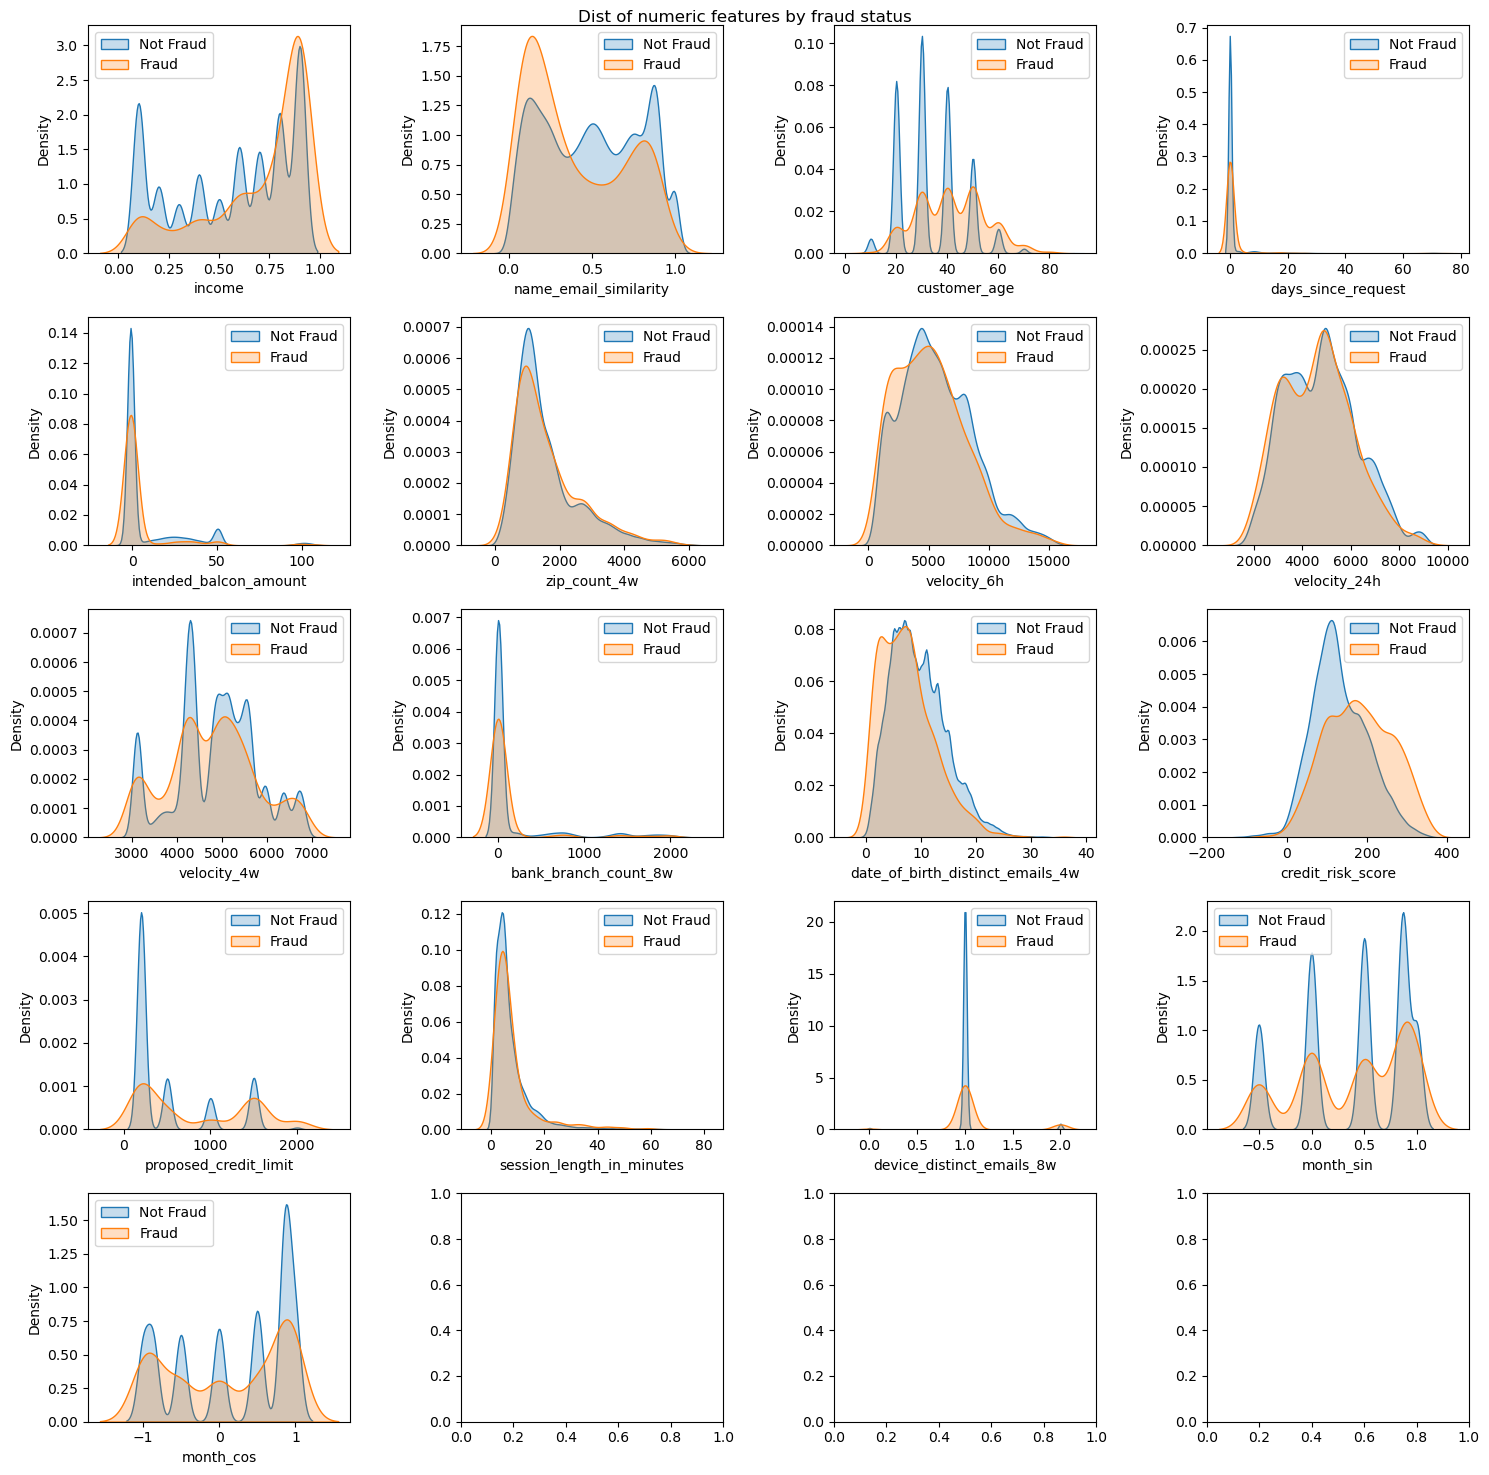

In [79]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
axes = axes.flatten()

fig.suptitle('Dist of numeric features by fraud status')

for i, feature in enumerate(numeric_columns):
    ax = axes[i]
    sns.kdeplot(data=df_resample_temp[df_resample_temp['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud')
    sns.kdeplot(data=df_resample_temp[df_resample_temp['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud')
    ax.set_xlabel(feature)
    ax.legend()

plt.tight_layout()
plt.show()


Dicussion: Somewhat interesting, can see the distributions **appear** different, sometimes in overall shape (date_of_birth_distinct_emails_44), sometimes just in mean (credit_risk_score), or just in variance (device_distinct_emails_8w, intended_balcon_amount...etc). Careful not to read to much into this - since both datasets have very different sample sizes. We will repeat this analysis later using near miss

##### Plot: Boxplot fraud vs non fraud 

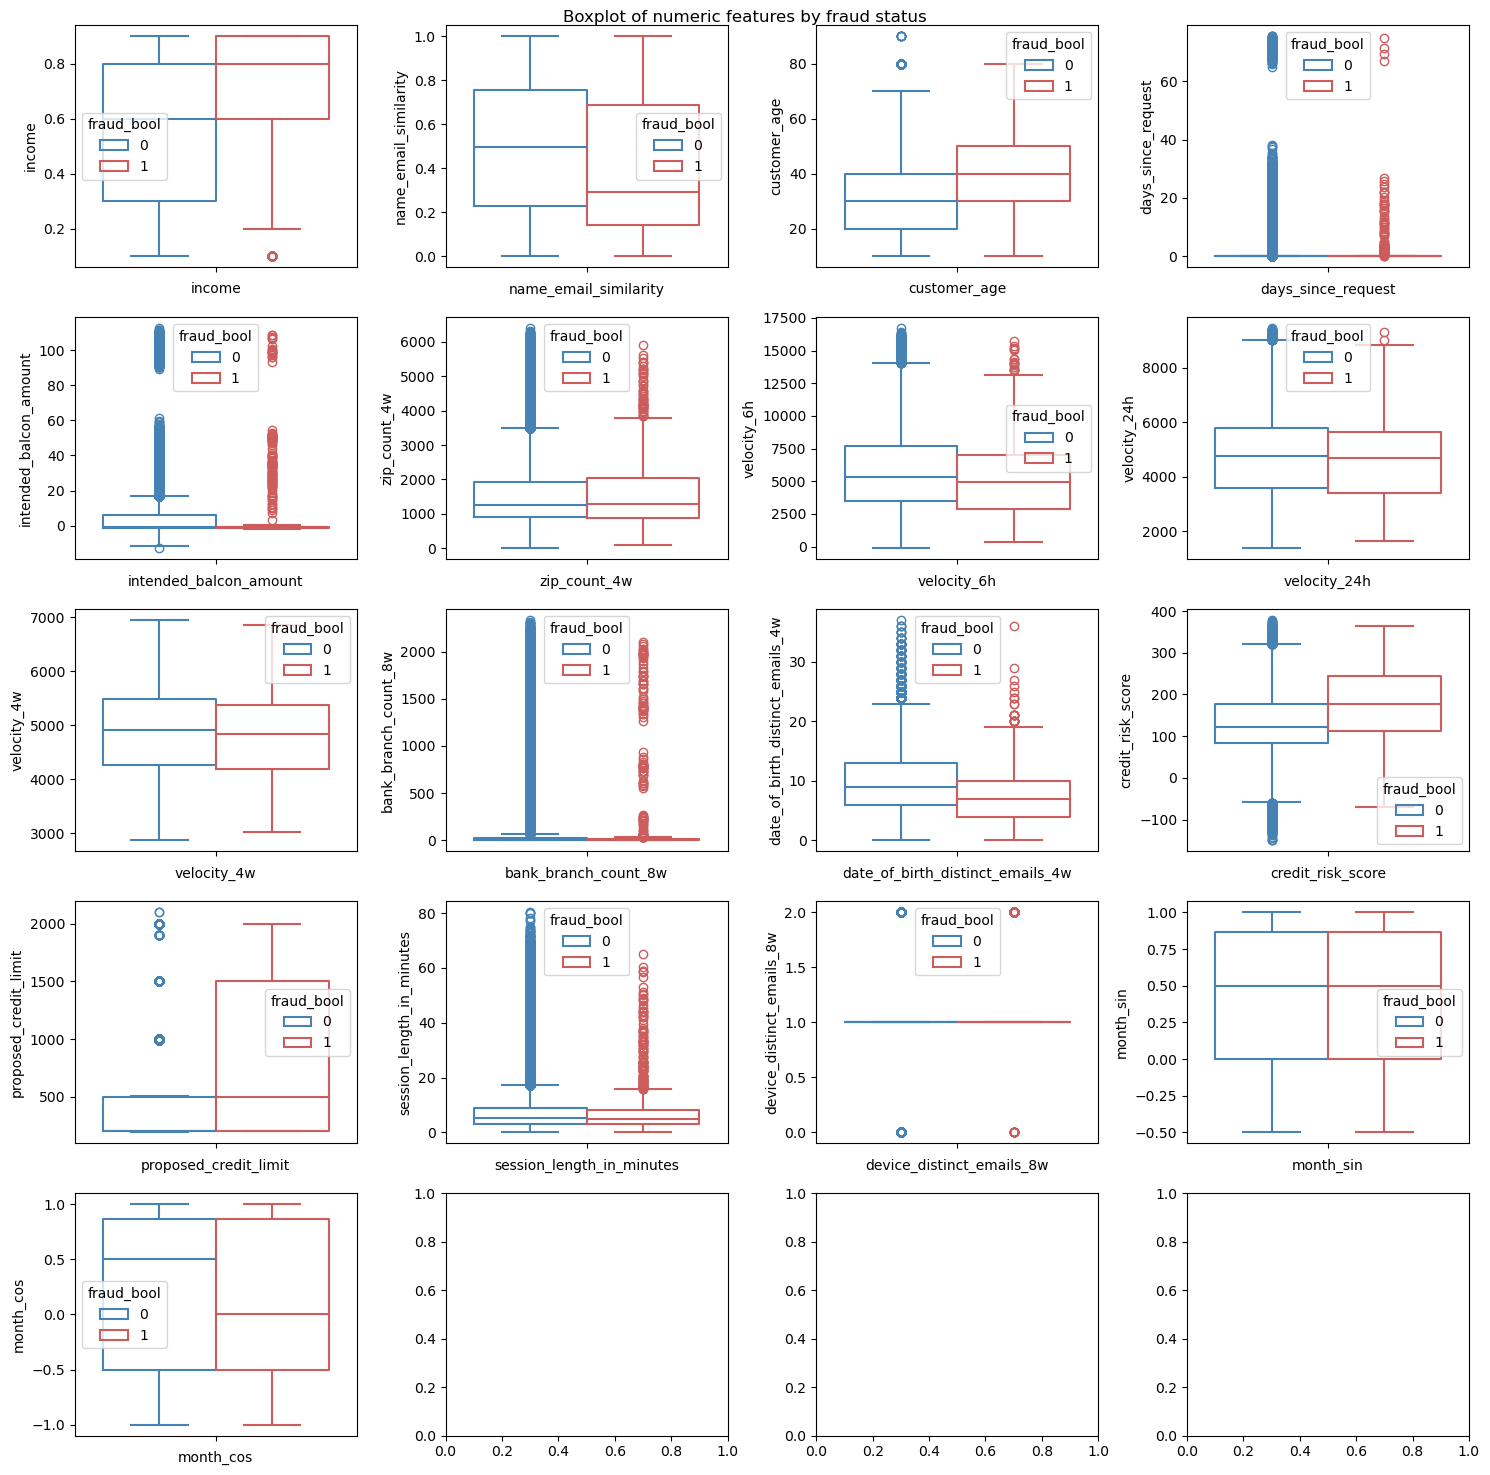

In [80]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
axes = axes.flatten()
fig.suptitle('Boxplot of numeric features by fraud status')

for i, feature in enumerate(numeric_columns):
    ax = axes[i]
    sns.boxplot(data=df_resample_temp, hue='fraud_bool', y=feature, ax=ax, fill = False,palette={0: "steelblue", 1: "indianred"})
    ax.set_xlabel(feature)

plt.tight_layout()
plt.show()

## Scaling Choices

Lets just look at the distribution of individual features

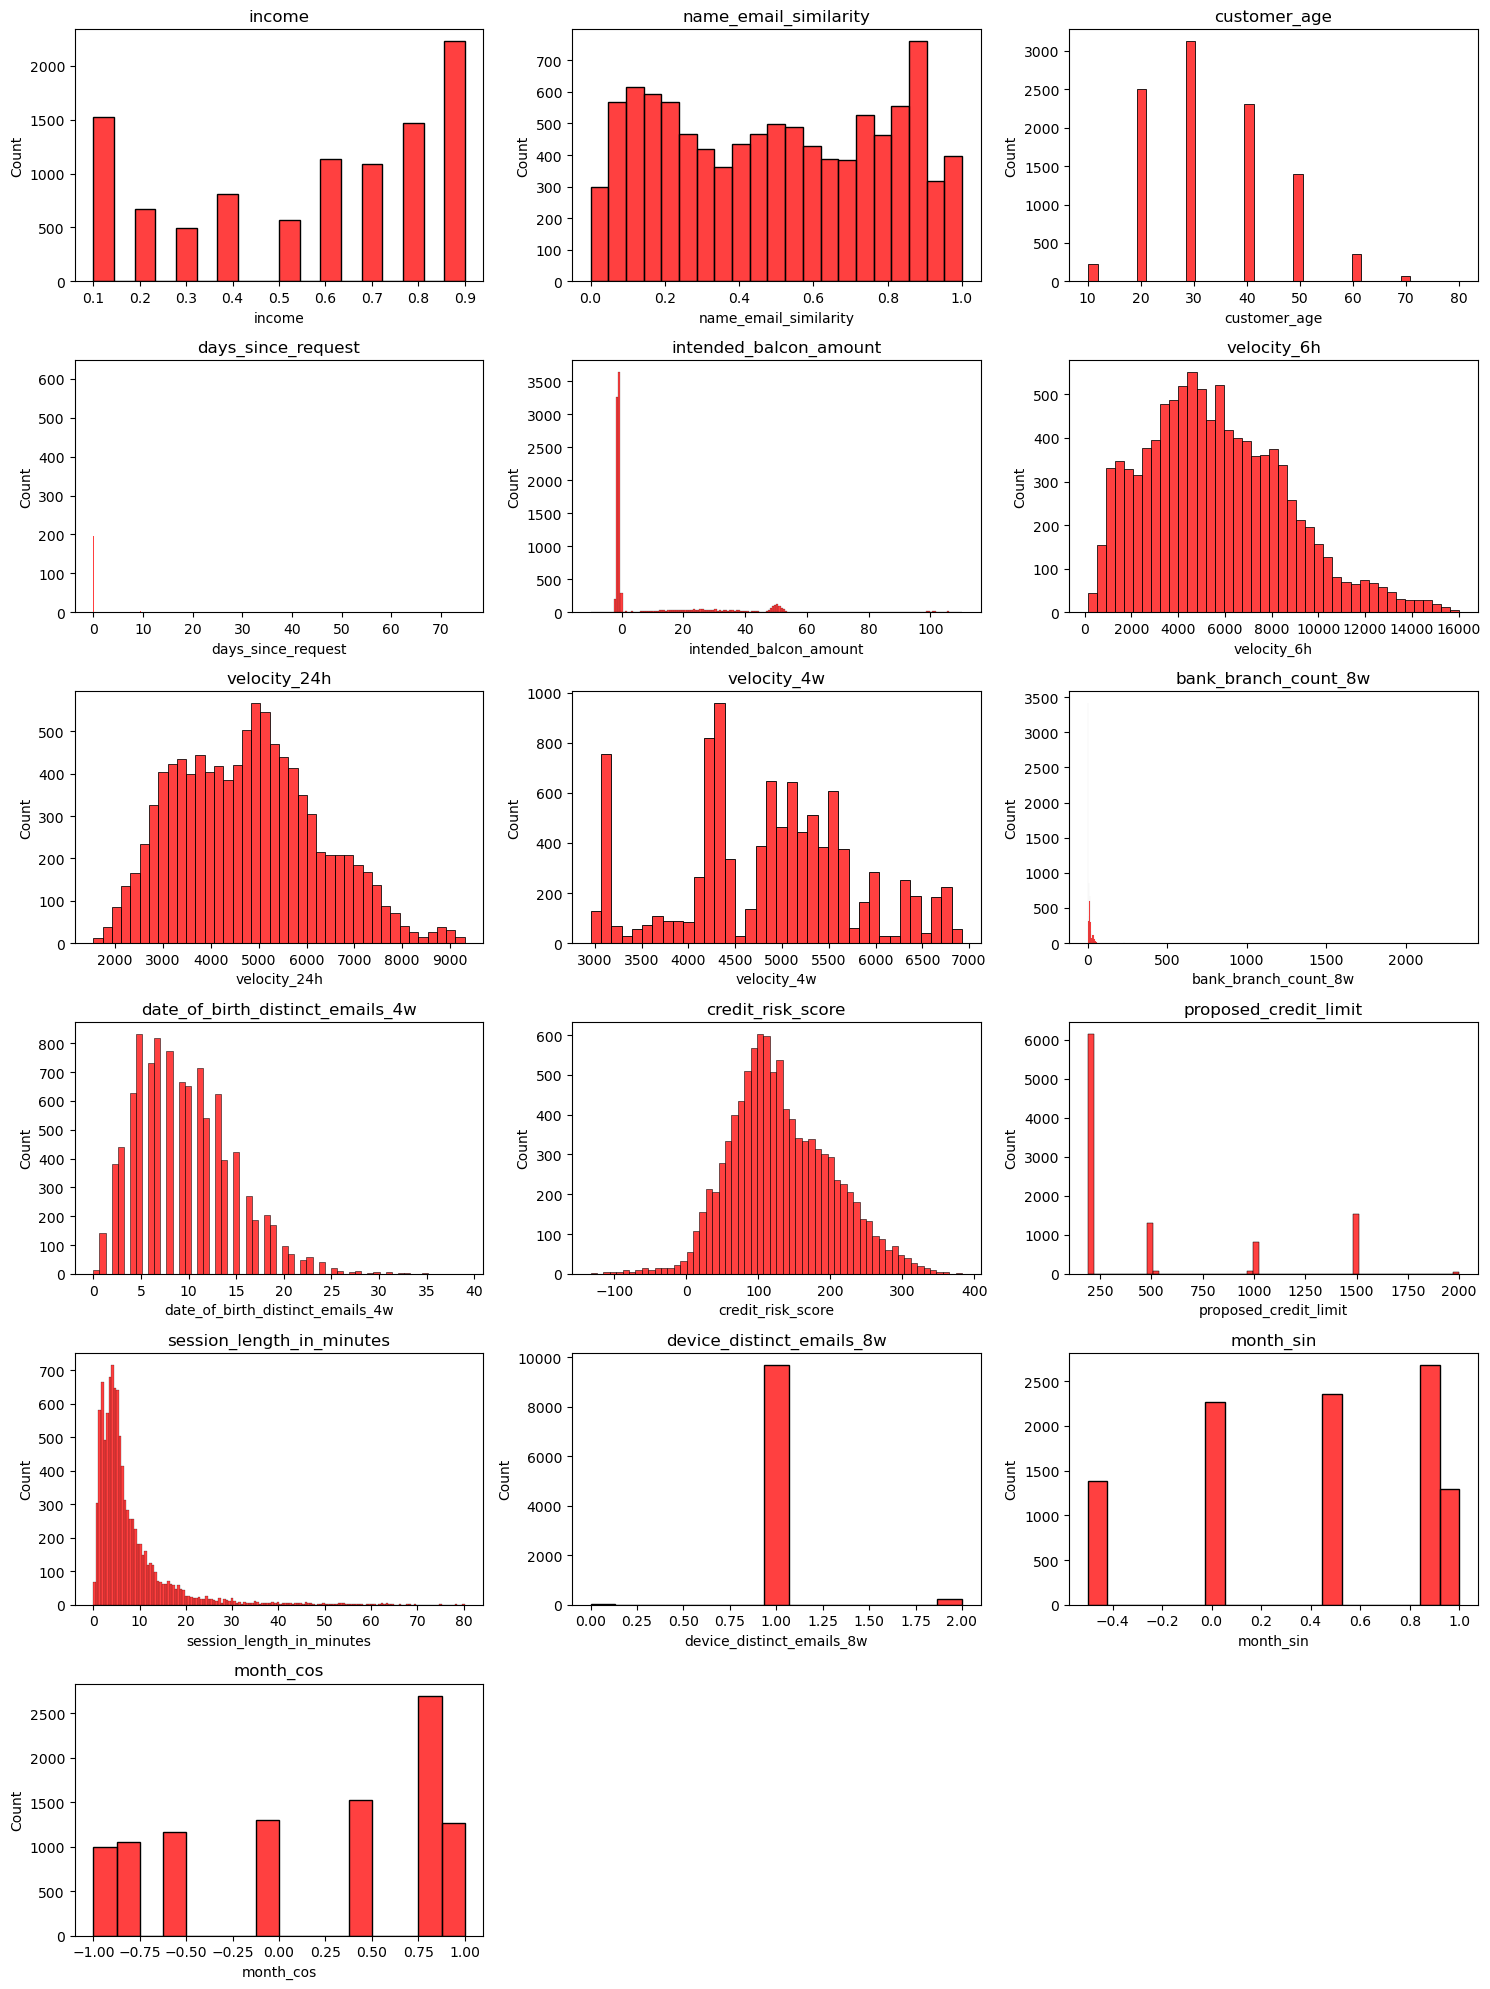

In [321]:
n = len(numeric_columns)
cols = 3  # or choose dynamically if you want
rows = n // cols + 1 

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
ax = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.histplot(data=df_resample_temp, x=column, ax=ax[i], color='r')
    ax[i].set_title(column)

# hide unused subplots
for j in range(i+1, len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()

From this we can see a few things 
1. intendend_balcon_amount, bank_branch_count_8w, days_since_request  look heavily skewed and have high variance, need to check these in detail 
2. Standard scaler will work for the rest
3. days_since_request looks like a zero inflated variable 

Lets take a closer look at some of the odd looking distributions and see what scaling does to them 

### days_since_request

In [ ]:
pt = PowerTransformer(method='yeo-johnson')   # or 'box-cox' if no negatives
df_test = pt.fit_transform(df_resample_temp[["days_since_request"]])
    
sns.histplot(x="days_since_request", data=df_test)

Power transfroms seem to be a good fit here with such heavily inbalanced data, seems like we can perserve the outlier signals 

### bank_branch_count_8w

In [ ]:
df_test = StandardScaler().fit_transform(df_resample_temp[["bank_branch_count_8w"]])
sns.histplot(x="bank_branch_count_8w", data=df_test)

Going to keep this with just a standard scaler only have 4 sigmas not insane variance

### intended_balcon_amount

In [ ]:
df_test = StandardScaler().fit_transform(df_resample_temp)[["intended_balcon_amount"]])
sns.histplot(x="intended_balcon_amount", data=df_test)

## Final Preproccessing Pipelines

From the scaling results of the Scaling Choices section - define the preprocessing pipelines

In [13]:
# Split the numeric columns into two depending on type of transformation needed
pw_sc_columns = ["days_since_request"] # Power transformer 
standard_columns = [x for x in numeric_columns if x not in (pw_sc_columns + ['month_sin', 'month_cos'])] # use standard scalers for all other variables + no encoding for sin and cos

In [38]:
# General numeric transformer 
numeric_trans = ColumnTransformer([
    ('power', PowerTransformer(method='yeo-johnson') , pw_sc_columns),
    ('standard', StandardScaler(), standard_columns),
], remainder='passthrough')

# One hot encoder for categorical variables
cat_trans = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32))
])

# Define scale + encoder preproccessor 
scale_encoder_processor = ColumnTransformer([
    ('numeric_scale', numeric_trans, numeric_columns),
    ('categorical_encode', cat_trans, category_columns)
], remainder='passthrough')

# Encode only 
encode_only_processor = ColumnTransformer([
    ('encode', cat_trans, category_columns),
], remainder='passthrough' )

# Feature Selection

Lets take a high level look at our features and see if we can determine which are relavant  + analysis multicolinearity

In [84]:
# Fit transformer, apply one hot encoding + scaling
scale_encoder_processor.fit(df)
df_scaled = scale_encoder_processor.transform(df)
df_scaled.columns = [col.split("__")[-1] for col in df_scaled.columns ]
bin_encode_columns = df_scaled.columns[~df_scaled.columns.isin(numeric_columns)].tolist()
bin_encode_columns.remove('fraud_bool')

## Variance Analysis

Quick check can see the variance has been reduced by the scalers to 1 as expected. Could make an arguement that you could scale cos and sin values of months, doesnt seem super helpful needed here variance and values are small already

In [88]:
df_scaled[numeric_columns].var()

income                              1.000001
name_email_similarity               1.000001
customer_age                        1.000001
days_since_request                  1.000001
intended_balcon_amount              1.000001
zip_count_4w                        1.000001
velocity_6h                         1.000001
velocity_24h                        1.000001
velocity_4w                         1.000001
bank_branch_count_8w                1.000001
date_of_birth_distinct_emails_4w    1.000001
credit_risk_score                   1.000001
proposed_credit_limit               1.000001
session_length_in_minutes           1.000001
device_distinct_emails_8w           1.000001
month_sin                           0.249978
month_cos                           0.540537
dtype: float32

## Pearsons Correlation and Multicolinearity

Lets view the correlation matrix

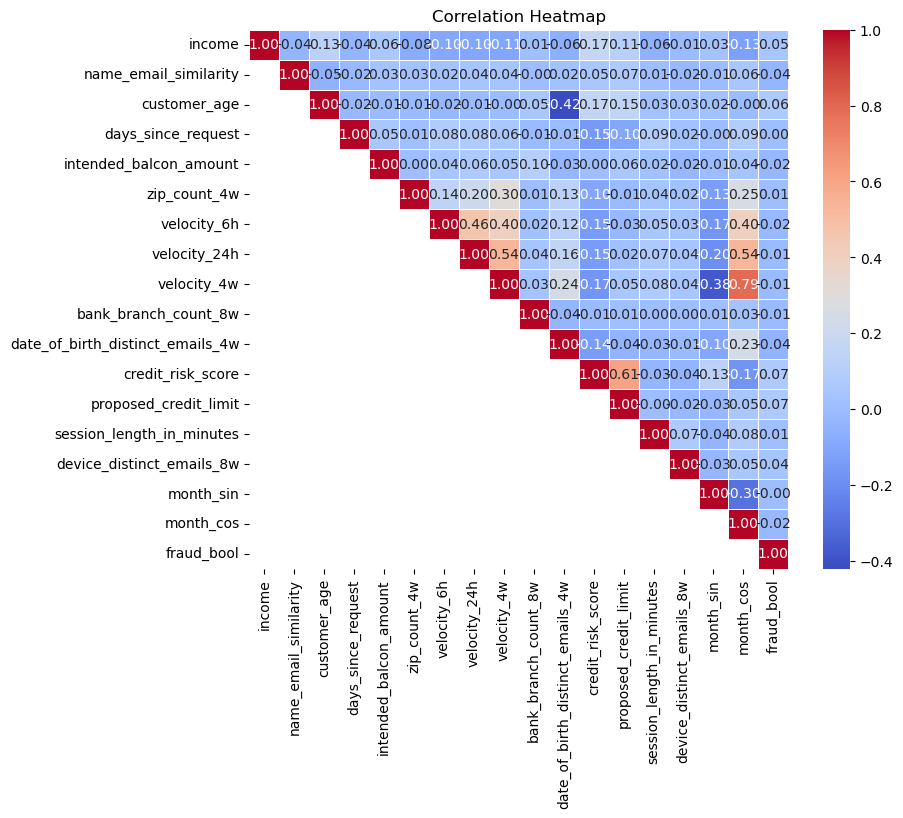

In [ ]:
corr_mat = df_scaled[numeric_columns + ['fraud_bool']].corr()
corr_mat_ut = corr_mat.where(np.triu(np.ones(corr_mat.shape)).astype(bool)) # i like just keep the upper triangular half makes it easier to look at 

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr_mat_ut, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, square=True, ax=ax)
plt.title('Correlation Heatmap')
plt.show()


Discussion: Somewhat interesting results, some features are correlated (highest is .79, general best practice is >.85 filter), no strong linear correlation between cts features and fraud bool. Nothing easy to filter out here 

## Chi Square 

Try and quantify how imporant categorical variables are - and which are most important. First we will use the chi2_contingency from the scipi package - this is a traditional chi square test (do not OHE this losses information) - will do this to see if there are any categories that clearly have no information. Then will check with sklearn chi2 test, this one is made to be used on OHE data.

In [93]:
for col in category_columns: 
    table = pd.crosstab(df[col], df["fraud_bool"])
    chi2, p, dof, expected = chi2_contingency(table)
    print(col, p)


payment_type 0.0
employment_status 0.0
housing_status 0.0
device_os 0.0


No easy wins here - moving on the encoded dataframe

In [102]:
chi2_results  = chi2(df_scaled[bin_encode_columns], df_scaled['fraud_bool'])
chi2_results_df = pd.DataFrame(data={'feature': bin_encode_columns, 'chi2': chi2_results[0], 'p_value': chi2_results[1]})

Check which variables are flagged as "not important" 

In [ ]:
large_p_filter = chi2_results_df['p_value'] > 0.1  # general threshold is .05 find that too liberal 
chi2_results_df[large_p_filter]

,feature,chi2,p_value
1,payment_type_AB,1.670125,0.196242
3,payment_type_AD,0.468897,0.493495
4,payment_type_AE,1.517859,0.217944
11,employment_status_CG,0.812677,0.367330
18,housing_status_BG,1.151813,0.283170
23,device_os_x11,0.020859,0.885163


All of these have very large p values (accept null, fraud_bool is independent of the above columns) - therefore can be safely dropped 

## Mutual Information Test for Numeric Features

Mutal information is a nice general test for independence, useful for parsing cts features for classifiers. There are some major drawbacks (you need to guess or estimate the joint distribution.) I generally only drop values that have a score of absolutely 1 

In [ ]:
mi_scores = mutual_info_classif(df_scaled[numeric_columns], df_scaled['fraud_bool'], discrete_features='auto')
mi_df = pd.DataFrame({'feature': numeric_columns, 'MI': mi_scores})

In [ ]:
mi_df.sort_values('normal', ascending = False)

,feature,MI,normal
12,proposed_credit_limit,0.078734,0.397031
2,customer_age,0.045756,0.230734
0,income,0.033008,0.166448
14,device_distinct_emails_8w,0.019938,0.100544
10,date_of_birth_distinct_emails_4w,0.009499,0.047901
9,bank_branch_count_8w,0.005199,0.026216
11,credit_risk_score,0.002959,0.014923
1,name_email_similarity,0.000970,0.004892
4,intended_balcon_amount,0.000785,0.003957
7,velocity_24h,0.000465,0.002346


zip_count_4w found to be completely independent of fraud_bool

## Summary

After running chi square and MIT we found that 
payment_type_AB, payment_type_AD, payment_type_AE, employment_status_CG, housing_status_BG, device_os_x11, month_0, month_4 were all independent of fraud_bool, 
same with the cts feature zip_count_4w

In [49]:
drop_columns = ['payment_type_AB', 'payment_type_AD', 'payment_type_AE', 'employment_status_CG', 'housing_status_BG', 'device_os_x11', 'zip_count_4w']

def drop_func(df):
    df.columns = [col.split("__")[-1] for col in df.columns ]
    return df.drop(drop_columns, axis =1, errors="ignore")

dropper = FunctionTransformer(drop_func)

clean_encode_processor = Pipeline([
    ("prep", scale_encoder_processor),
    ("drop", dropper),
])

In [16]:
df_scaled = clean_encode_processor.fit_transform(df)

# Dimensional Reduction

We have now defined new scalers - want to see how that has changed the distribution of data. Lets also apply near miss for down sampling since this is what we will use for training anyway

Why choose .7 as the resampling ratio? did some experimenting and I found that keeping the threshold at 1:1 removed a bit too much data. Specifically it would include no NO FRAUD samples from device_distinct_emails, were loosing some critical details

In [26]:
# Apply near miss resampling 
X_sample, y_sample = NearMiss(sampling_strategy= .7).fit_resample(df_scaled.drop(['fraud_bool'], axis = 1), df['fraud_bool'])

# Create new combined dataframe
df_resample_nm = X_sample.copy()
df_resample_nm['fraud_bool']=  y_sample

## Dimensionality Reducation Pipelines

Im interested in if demonsion reduction could help here - we have multicolinearity data that we could elimate with PCA, similiarly MCA could help reduce the extra varaince from the many new categories created by one hot encoding.

In [ ]:
#  ---------------- Define processor for PCA + Encoding
numeric_trans_to_PCA = Pipeline([
    ('scaler', numeric_trans),
    ('pca', decomposition.PCA(n_components=13, random_state=42))
])

# Use MCA here to reduce categorical features instead of one hot encoding 
mca_trans = Pipeline([
    ('mca', prince.MCA(
        n_components=20, # Some back and forth each further iteration loses ~2% of variance, max is 24 
        n_iter=4,
        copy=True, # ensure doesnt modify in place 
        check_input=True,
        engine='sklearn',
        random_state=42
    ))
])

# ------------ Dimension reducation methods we want to investigate 
# Perform pca and OHE 
pca_processor = ColumnTransformer([
    ('PCA', numeric_trans_to_PCA, numeric_columns),
    ('encode', cat_trans, category_columns)
], remainder='passthrough')

# Perform MCA and scale numeric columns
mca_processor = ColumnTransformer([
    ('scaling', numeric_trans, numeric_columns),
    ('MCA', mca_trans, (category_columns + binary_columns))
], remainder='passthrough')

# Perform both PCA and MCA 
pca_mca_processor = ColumnTransformer([
    ('PCA', numeric_trans_to_PCA, numeric_columns),
    ('MCA', mca_trans, (category_columns + binary_columns))
], remainder='passthrough')

### Verification

Create the final dataframes, then apply near miss

In [18]:
# Fit to dataframes
pca_encode_df = pca_processor.fit_transform(df)
mca_scale_df = mca_processor.fit_transform(df)
pca_mca_df = pca_mca_processor.fit_transform(df) 

# Col cleaning
pca_encode_df.columns = [col.split("__")[-1] for col in pca_encode_df.columns ]
mca_scale_df.columns = [col.split("__")[-1] for col in mca_scale_df.columns ]
pca_mca_df.columns = [col.split("__")[-1] for col in pca_mca_df.columns ]

# Create NM datasets 
pca_encode_df_nm, y,  = NearMiss(sampling_strategy= .7).fit_resample(pca_encode_df.drop(['fraud_bool'], axis =1 ), df['fraud_bool'])
pca_encode_df_nm['fraud_bool'] = y 

mca_scale_df_nm, y = NearMiss(sampling_strategy= .7).fit_resample(mca_scale_df.drop(['fraud_bool'], axis =1 ), df['fraud_bool'])
mca_scale_df_nm['fraud_bool'] = y 

pca_mca_df_nm, y = NearMiss(sampling_strategy= .7).fit_resample(pca_mca_df.drop(['fraud_bool'], axis =1 ), df['fraud_bool'])
pca_mca_df_nm['fraud_bool'] = y 

Check what the PCA and MCA outputs look like, can see we have high percent of variance explained for PCA, MCA percent of variance doesnt map 1:1. Also can see the PCA eigenvectors look like a good combination of features - arent dominated by a single one (good sign)

In [19]:
# Get the PCA values
print(" -------------------- PCA: ")
pca = pca_processor.named_transformers_['PCA'].named_steps['pca']
loadings = pd.Series(pca.components_[0], index=numeric_columns)

print(loadings.abs().sort_values(ascending=False).head(10))
print("PCA Variance Explained: " , pca.explained_variance_ratio_.sum())

# Get the MCA values 
print(" -------------------- MCA: ")
mca = pca_mca_processor.named_transformers_['MCA'].named_steps['mca']

print("MCA total inertia: " ,mca.total_inertia_)
print(mca.eigenvalues_summary)

 -------------------- PCA: 
velocity_4w                         0.465844
velocity_24h                        0.451637
velocity_6h                         0.405819
credit_risk_score                   0.337813
date_of_birth_distinct_emails_4w    0.289021
zip_count_4w                        0.278364
name_email_similarity               0.203922
proposed_credit_limit               0.184115
days_since_request                  0.178805
income                              0.134187
dtype: float32
PCA Variance Explained:  0.94777477
 -------------------- MCA: 
MCA total inertia:  2.833333333333313
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.131         4.62%                      4.62%
1              0.113         3.99%                      8.61%
2              0.109         3.84%                     12.45%
3              0.103         3.65%                     16.10%
4              0.103         3.62

## T-SNE 
Want to check if any of the above dataframes show clear clustering of the fraud non fraud, see what effects of sampling and near miss have on the folds as well. Main goal is see if any natural clusters form / if the topology clearly shows fraud cases being seperate. Resampling will probably be needed here to correct for class imbalance

In [ ]:
X_SNE_pca_NM = TSNE(n_components=2, random_state=42).fit_transform(pca_encode_df_nm.drop('fraud_bool', axis =1)).values 
X_SNE_MCA_NM = TSNE(n_components=2, random_state=42).fit_transform(mca_scale_df_nm.drop('fraud_bool', axis =1)).values 
X_SNE_pca_MCA_NM = TSNE(n_components=2, random_state=42).fit_transform(pca_mca_df_nm.drop('fraud_bool', axis =1)).values 
X_SNE_OHE_SCAL_NM =TSNE(n_components=2, random_state=42).fit_transform(df_resample_nm.drop('fraud_bool', axis =1)).values 

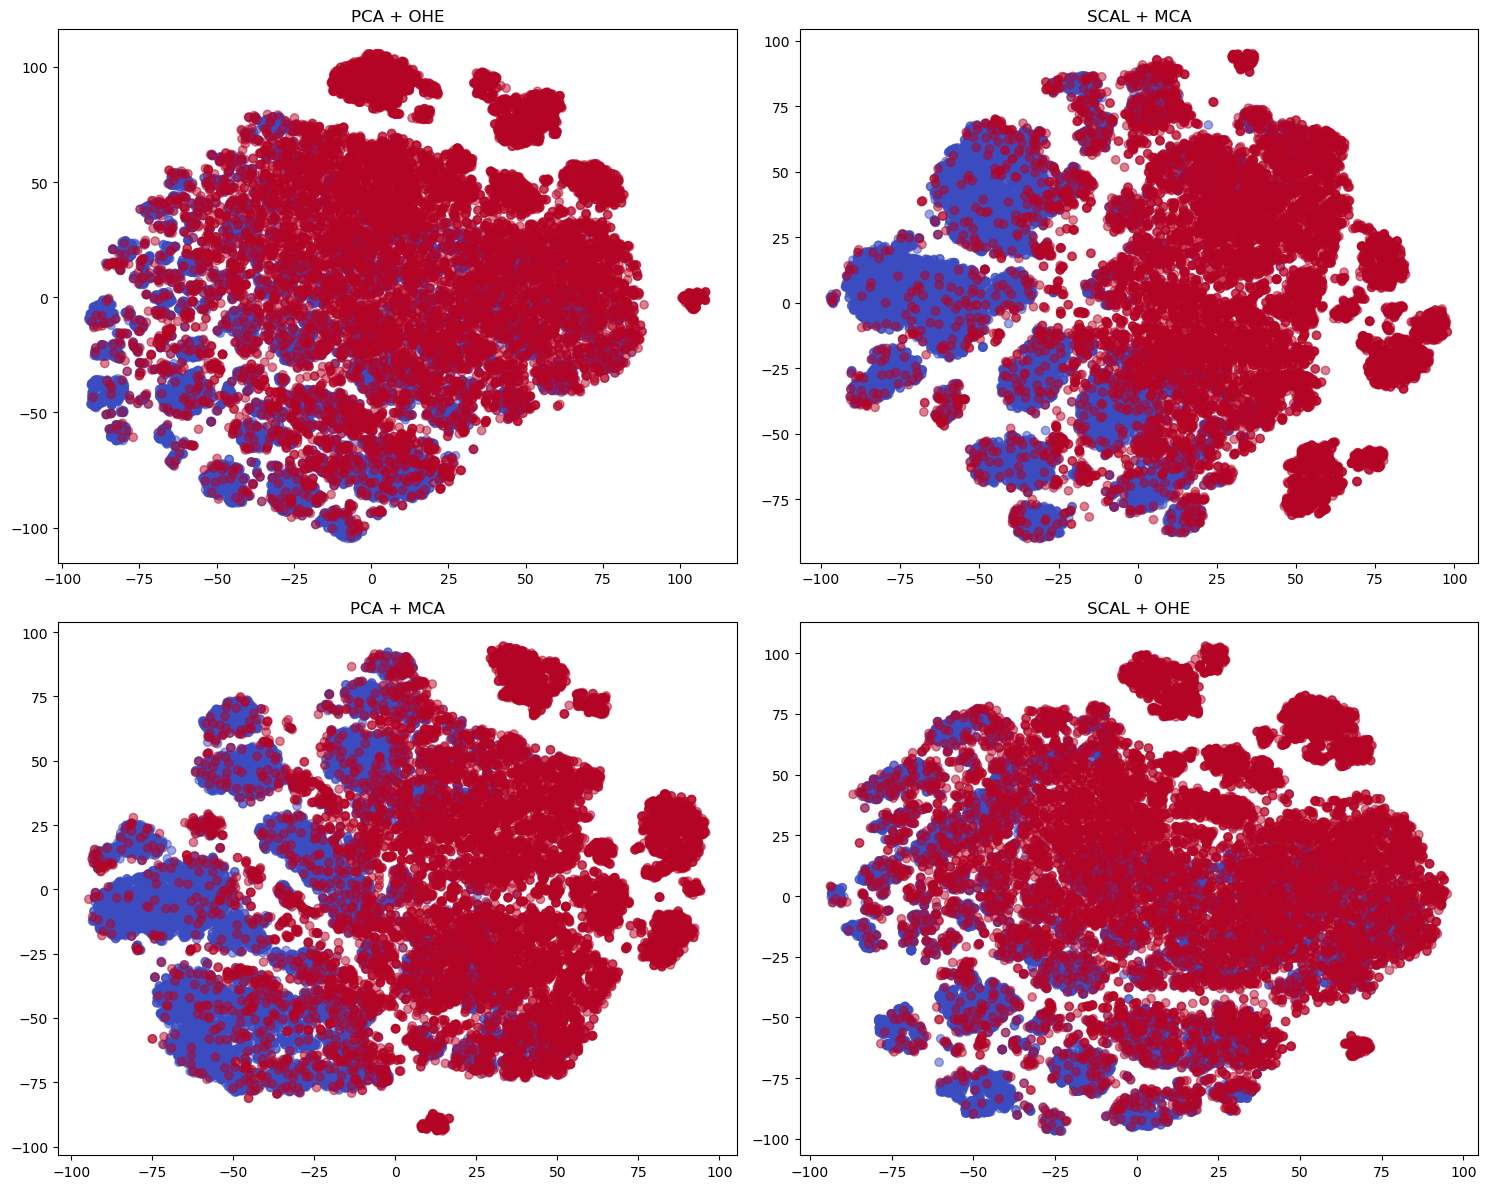

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs[0, 0].scatter(X_SNE_pca_NM[:, 0], X_SNE_pca_NM[:, 1], c=pca_encode_df_nm['fraud_bool'], cmap='coolwarm', alpha=0.5)
axs[0, 0].set_title('PCA + OHE')
axs[0, 1].scatter(X_SNE_MCA_NM[:, 0], X_SNE_MCA_NM[:, 1], c=mca_scale_df_nm['fraud_bool'], cmap='coolwarm', alpha=0.5)
axs[0, 1].set_title('SCAL + MCA')
axs[1, 0].scatter(X_SNE_pca_MCA_NM[:, 0], X_SNE_pca_MCA_NM[:, 1], c=pca_mca_df_nm['fraud_bool'], cmap='coolwarm', alpha=0.5)
axs[1, 0].set_title('PCA + MCA')
axs[1, 1].scatter(X_SNE_OHE_SCAL_NM[:, 0], X_SNE_OHE_SCAL_NM[:, 1], c=df_resample_nm['fraud_bool'], cmap='coolwarm', alpha=0.5)
axs[1, 1].set_title('SCAL + OHE')
plt.tight_layout()
plt.show()

## Summary

TSNE for SCAL + MCA, and PCA + MCA shows some distinct clustering, PCA + OHE and SCAL + OHE show less clear clustering, it seems that some dimensional reduction on the categories can help seperate them out. Going to move all of these approaches onto the modeling stage 

# Baseline Models

WARNING ON SAMPLING: For most of this project we were using the NearMiss algorithm. Below, when I used NearMiss, ROC scores for the models hovered around 0.45. Changing to random undersampling bumped them to 0.85. It seems that under PCA and MCA, NearMiss is failing to sample the “close” features and instead is erasing critical signal. It turns out NearMiss is a bad sampling method for this problem — simply removing too much signal. This is intereting because our above TSNE plots with NearMiss do show some class seperation with PCA+ MCA and SCAL + MCA, its possible TSNE is overly exaggerating the distance, UMAP could have been a better technique. 

Instead, SMOTE for oversampling would probably be superior (my computer can’t run it, however). Random undersampling is the next best thing and what we will be using for the training runs.
To make this a better analysis, I should probably rerun the dimensional reduction section with RandomUnderSampler instead.

In [ ]:
# Setup preproccessors we want to test 
preproccesors_dict = {
    "PCA + OHE": pca_processor,
    "SCAL + MCA": mca_processor,
    "PCA + MCA": pca_mca_processor,
    "SCAL + OHE + DROP" : clean_encode_processor, 
    "OHE" : encode_only_processor,
}

# Setup models we want to test 
models = {
    "LogReg": LogisticRegression(max_iter=2000, solver="saga", penalty="l1"),
    "RF": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0),
    "XGB": xgb.XGBClassifier(
        n_estimators=1200, max_depth=6, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, tree_method="hist",
        eval_metric="aucpr", n_jobs=-1, random_state=0    ),
    "LGBM": lgb.LGBMClassifier(
        objective="binary",
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        verbosity=-1,
        n_jobs=-1,
        random_state=0,
    ),
    "DT": DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=20,
        min_samples_leaf=5,
        random_state=0
    ),
}


## Experiment

In [ ]:
# Define cross validation 
sss = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)

# Shuffle dataframe
df = df.sample(frac=1, random_state=42)

# Extract features and response again
y = df['fraud_bool']
X = df[feature_columns] 

# To keep track of the results 
results = []

# Iterate through each split 
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    # Get split 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for preprocessor_name, pre_processor in preproccesors_dict.items():
        # Define Transformer 
        
        # pipe = ImbPipeline([
        #         ('pre', pre_processor),
        #         ('nm', NearMiss(sampling_strategy=.7)),
        # ])
        
        # Resample the training data - this also fits the pre_proccessor 
        X_scale_train = pre_processor.fit_transform(X_train)
        X_trans_train, y_trans_train = RandomUnderSampler(sampling_strategy=0.7, random_state=42).fit_resample(X_scale_train, y_train)

        # Apply the same preproccessor to the test dataset 
        X_trans_test = pre_processor.transform(X_test)

        # type cast 
        X_trans_train = X_trans_train.astype(np.float32, copy=False)
        X_trans_test  = X_trans_test.astype(np.float32,  copy=False)

        for model_name, base_model in models.items():
            # Clone the base model 
            model = clone(base_model)  
            
            # Bit the model and get predictions 
            model.fit(X_trans_train, y_trans_train)
            y_pred = model.predict(X_trans_test)

            # Compute f1
            f1_score_val = f1_score(y_test, y_pred)

            # Get ROC_AUC info 
            y_prob = model.predict_proba(X_trans_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_prob)

            # Package into outputs 
            out_dict = {
                'Preprocessor': preprocessor_name,
                'Model': model_name,
                'ROC_AUC': roc_auc,
                'F1_Score': f1_score_val,
                'fold': i
            }
            print(out_dict)

            # Add results to list 
            results.append(out_dict)

results_df = pd.DataFrame(results, columns=[
    'Preprocessor', 'Model', 'ROC_AUC', 'F1_Score', 'fold',
])

results_df.to_csv('base_model_stats')

{'Preprocessor': 'PCA + OHE', 'Model': 'LogReg', 'ROC_AUC': 0.850649083146508, 'F1_Score': 0.13173333333333334, 'fold': 0}
{'Preprocessor': 'PCA + OHE', 'Model': 'RF', 'ROC_AUC': 0.8368310963184898, 'F1_Score': 0.10974046779878244, 'fold': 0}
{'Preprocessor': 'PCA + OHE', 'Model': 'XGB', 'ROC_AUC': 0.8432426384249764, 'F1_Score': 0.11563938475356461, 'fold': 0}
{'Preprocessor': 'PCA + OHE', 'Model': 'LGBM', 'ROC_AUC': 0.8436721764525889, 'F1_Score': 0.11380871842435485, 'fold': 0}
{'Preprocessor': 'PCA + OHE', 'Model': 'DT', 'ROC_AUC': 0.725876419615018, 'F1_Score': 0.0615560713490827, 'fold': 0}
{'Preprocessor': 'SCAL + MCA', 'Model': 'LogReg', 'ROC_AUC': 0.8446150454389474, 'F1_Score': 0.16167984612096603, 'fold': 0}
{'Preprocessor': 'SCAL + MCA', 'Model': 'RF', 'ROC_AUC': 0.8351105930115317, 'F1_Score': 0.1246359544612126, 'fold': 0}
{'Preprocessor': 'SCAL + MCA', 'Model': 'XGB', 'ROC_AUC': 0.8404543499486183, 'F1_Score': 0.1307957968991109, 'fold': 0}
{'Preprocessor': 'SCAL + MCA',

In [103]:
# Get the top 5 models by ROC_AUC
(results_df
 .groupby(by = ['Preprocessor', 'Model'], as_index=False)
 .mean()
 .drop('fold', axis =1)
 .sort_values(by = "ROC_AUC", ascending=False)
 .head(15)
)

,Preprocessor,Model,ROC_AUC,F1_Score
12,PCA + OHE,LogReg,0.869381,0.106897
22,SCAL + OHE + DROP,LogReg,0.869228,0.103122
17,SCAL + MCA,LogReg,0.864393,0.098734
7,PCA + MCA,LogReg,0.863211,0.103136
14,PCA + OHE,XGB,0.861693,0.091314
11,PCA + OHE,LGBM,0.861321,0.090914
9,PCA + MCA,XGB,0.859597,0.091324
6,PCA + MCA,LGBM,0.858023,0.089096
13,PCA + OHE,RF,0.857713,0.094650
8,PCA + MCA,RF,0.853472,0.093797


Interesting enough Log Reg dominates. Purely ancedotal but I have found that when logreg performs well it means feature engineering was done correctly, logreg is a simple model and can find insights. 

In [109]:
(results_df[['Preprocessor', 'ROC_AUC']]
 .groupby(by = ['Preprocessor'], as_index=False)
 .mean()
 .sort_values(by = "ROC_AUC", ascending=False)
)

,Preprocessor,ROC_AUC
2,PCA + OHE,0.842033
1,PCA + MCA,0.840179
4,SCAL + OHE + DROP,0.793178
3,SCAL + MCA,0.783387
0,OHE,0.768400


Can also see that on average PCA does do signifcantly better then just normal scaling, also dropping columns from feature selection has a small model improvement - if we wanted to investigate this more could do more folds and a T or Welch - test 

Will continue with the following pipelines
1. PCA + OHE and LogReg
2. PCA + OHE and XGB 
2. PCA + MCA and LGBM 
Will also add a step to drop the uneeded encoded features 

# Model Tunning

## Final Pipelines
I like to rewrite the entire pipelines out explicility so we don't have to scower the notebook to see how things are put together + easier to debug and add new components

In [ ]:
# -------------- Columns classes 
# Define all feature columns 
feature_columns = df.columns.tolist()
feature_columns.remove('fraud_bool')
feature_columns.remove('zip_count_4w')

# Binary columns
binary_columns = ['email_is_free','source',
                   'phone_home_valid', 'phone_mobile_valid', 
                   'has_other_cards', 'foreign_request', 'keep_alive_session']

# Columns that will need 1 hot encoding 
category_columns = ['payment_type', 'employment_status', 'housing_status', 'device_os'] # Adding month here  

# Purely real numeric columns 
numeric_columns = [x for x in feature_columns if x not in (binary_columns+category_columns)]

# Numerical column split
pw_sc_columns = ["days_since_request"] # Power transformer 
standard_columns = [x for x in numeric_columns if x not in (pw_sc_columns + ['month_sin', 'month_cos'])] # use standard scalers for all other variables + no encoding for sin and cos

#  Encode columns to drop 
drop_columns_enc = ['payment_type_AB', 'payment_type_AD', 'payment_type_AE', 'employment_status_CG', 'housing_status_BG', 'device_os_x11']

# -------------- Function Transformers
# If we are encoding drop these features 
def drop_func(df):
    df.columns = [col.split("__")[-1] for col in df.columns ]
    return df.drop(drop_columns_enc, axis =1, errors="ignore")

dropper = FunctionTransformer(drop_func)

# Convert every column to float32
def to_float32(X):
    if isinstance(X, pd.DataFrame):
        return X.astype(np.float32)
    return X.astype(np.float32)

cast_float32 = FunctionTransformer(to_float32, feature_names_out='one-to-one')

# -------------- General numeric transformer 
numeric_trans = ColumnTransformer([
    ('power', PowerTransformer(method='yeo-johnson') , pw_sc_columns),
    ('standard', StandardScaler(), standard_columns),
], remainder='passthrough')

# Use MCA here to reduce categorical features instead of one hot encoding 
mca_trans = Pipeline([
    ('mca', prince.MCA(
        n_components=20, # Some back and forth each further iteration loses ~2% of variance, max is 24 
        n_iter=4,
        copy=True, # ensure doesnt modify in place 
        check_input=True,
        engine='sklearn',
        random_state=42
    ))
])

# -------------- Model Training Pipelines
pipe_logreg_PCA = Pipeline(steps=[
    ('pre', 
        ColumnTransformer([
            ('PCA', 
                Pipeline([
                    ('scaler', numeric_trans),
                    ('pca', decomposition.PCA(n_components=13, random_state=42))])
            , numeric_columns),
            ('encode',  
                OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32), 
            category_columns)
        ], remainder='passthrough')
    ),
    ("drop", dropper),
    ('conv32', cast_float32),
    ('clf', LogisticRegression(max_iter=2000, solver="saga", penalty="l1"))
])

pipe_xgb_PCA = Pipeline(steps=[
    ('pre', 
        ColumnTransformer([
            ('PCA', 
                Pipeline([
                    ('scaler', numeric_trans),
                    ('pca', decomposition.PCA(n_components=13, random_state=42))])
            , numeric_columns),
            ('encode',  
                OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32), 
            category_columns)
        ], remainder='passthrough')
    ),
    ("drop", dropper),
    ('conv32', cast_float32),
    ('clf', xgb.XGBClassifier(
        n_estimators=1200, max_depth=6, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, tree_method="hist",
        eval_metric="aucpr", n_jobs=-1, random_state=0)
    )
])

# dont need the drop step here since we dont OHE 
pipe_lgbm_PCA_MCA = Pipeline(steps=[
    ('pre',
    ColumnTransformer([
        ('PCA', 
            Pipeline([
                ('scaler', numeric_trans),
                ('pca', decomposition.PCA(n_components=13, random_state=42))])
        , numeric_columns),
        ('MCA',  
            mca_trans, 
        category_columns + binary_columns)
    ], remainder='passthrough')
    ),
    ('conv32', cast_float32),
    ('clf', lgb.LGBMClassifier(
        objective="binary",
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        verbosity=-1,
        n_jobs=-1,
        random_state=0,
    ))
])

## Data Prep

Whats not included: NA, dropping incomplete features (covered in first step of best data cleaning), encoding sin and cosine values. Split the dataframe, pass the training in for hyper parameter tunning and CV, hold back X_validation and y_validation for final testing

In [ ]:
# 'zip_count_4w' will not get caught by the dropper just remove it here 
X_total = df.drop(['zip_count_4w', 'fraud_bool'], axis =1 )
y = df['fraud_bool']

# Seperate out the training and validation sets 
X_train, X_validation, y_train, y_validation = train_test_split(X_total, y, test_size=0.2, random_state=0)

## Tunning

In [ ]:
xgb_dist = {
    "clf__learning_rate": loguniform(5e-3, 0.2),   
    "clf__n_estimators": randint(300, 1800),
    "clf__max_depth": randint(3, 11),                  
    "clf__min_child_weight": loguniform(0.5, 10),       
    "clf__subsample": uniform(0.5, 0.5),                
    "clf__colsample_bytree": uniform(0.4, 0.6),         
    "clf__gamma": loguniform(1e-3, 5),                  
    "clf__reg_lambda": loguniform(1e-2, 30),            
    "clf__reg_alpha": loguniform(1e-3, 5),              
    "clf__max_delta_step": randint(0, 6),
}

logreg_dist = {
    "clf__C": loguniform(1e-3, 10),              # inverse regularization strength
    "clf__fit_intercept": [True, False],
    "clf__class_weight": [None, "balanced"],
    "clf__tol": loguniform(1e-5, 1e-2),          # convergence tolerance
    "clf__l1_ratio": uniform(0, 1),              # only used if you switch to penalty='elasticnet'
}

lgbm_dist = {
    "clf__num_leaves": randint(15, 80),
    "clf__max_depth": randint(3, 12),
    "clf__learning_rate": loguniform(1e-3, 0.2),
    "clf__n_estimators": randint(300, 1500),
    "clf__subsample": uniform(0.6, 0.4),           # bagging fraction
    "clf__colsample_bytree": uniform(0.5, 0.5),    # feature fraction
    "clf__min_child_samples": randint(10, 100),
    "clf__reg_lambda": loguniform(1e-2, 30),
    "clf__reg_alpha": loguniform(1e-3, 10),
    "clf__scale_pos_weight": uniform(0.5, 2.0),    # can balance mild imbalance
    "clf__min_split_gain": loguniform(1e-3, 1.0),
}

# CV 
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Define search functons 
search_logreg = RandomizedSearchCV(
    estimator=pipe_logreg_PCA,
    param_distributions=logreg_dist,   
    n_iter=50,                     
    scoring='roc_auc',  
    n_jobs=-1,
    cv=cv,
    verbose=3,
    random_state=42
)

search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb_PCA,
    param_distributions=xgb_dist,    
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=3,
    random_state=42
)

search_lgbm = RandomizedSearchCV(
    estimator=pipe_lgbm_PCA_MCA,
    param_distributions=lgbm_dist,    
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=3,
    random_state=42
)

Training can take a long time here - especially using sampling methods. RandomizedUnderSampler isn't bad, however if we wanted to extend this analysis doing an undersampling on every run will be really slow. Instead precompute the split for each fold

In [279]:
sampled_cv_splits = []
for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_CV = X_train.iloc[train_index]
    y_train_CV = y_train.iloc[train_index]

    # Apply near miss and encoding 
    resampler = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
    resampler.fit_resample(X_train_CV, y_train_CV)

    # Get the indexes of down sampled step - then convert to indexes of X 
    new_index_train = resampler.sample_indices_
    global_index = train_index[new_index_train]
    
    # Append indexes back - keep original test_indexes (NEVER MODIFY)
    sampled_cv_splits.append((global_index, test_index))

sampled_cv_splits = [(np.asarray(tr, dtype=int), np.asarray(te, dtype=int))
                     for tr, te in sampled_cv_splits]

search_logreg.set_params(cv=sampled_cv_splits);
search_xgb.set_params(cv=sampled_cv_splits);
search_lgbm.set_params(cv=sampled_cv_splits);

In [ ]:
search_xgb.fit(X_train, y_train)

# Print best
print("Best Score:", search_xgb.best_score_)

# dump
best_xgb_model = search_xgb.best_estimator_
joblib.dump(best_xgb_model, "models/xgb_best_model.pkl")

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best CV ROC_AUC: 0.8740335190118971


['models/xgb_best_model.pkl']

In [280]:
search_logreg.fit(X_train, y_train)

# Print best
print("Best Score:", search_logreg.best_score_)

# dump
best_logreg_model = search_logreg.best_estimator_
joblib.dump(best_logreg_model, "models/best_logreg_model.pkl")


Fitting 4 folds for each of 50 candidates, totalling 200 fits


c:\Users\isaac\anaconda3\envs\credit_fraud\lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best CV ROC_AUC: 0.09948304618742719


['models/best_logreg_model.pkl']

In [ ]:
search_lgbm.fit(X_train, y_train)

# Print best
print("Best Score:", search_lgbm.best_score_)

# dump
best_lgbm_model = search_lgbm.best_estimator_
joblib.dump(best_lgbm_model, "models/best_lgbm_model.pkl")

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best CV ROC_AUC: 0.871248710731111


['models/best_search_lgbm.pkl']

# Model Assesment 

In [311]:
models = {
    "LogReg": best_logreg_model,
    "XGB": best_xgb_model,
    "lgbm": best_lgbm_model
}

## AUC and ROC curves

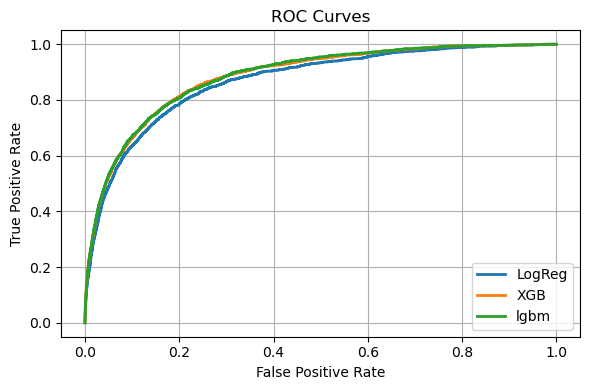

In [ ]:
scores = {}
auc_scores = {}

for name, model in models.items():
    y_prob = model.predict_proba(X_validation)[:, 1]
    fpr, tpr, _ = roc_curve(y_validation, y_prob)
    scores[name] = (fpr, tpr)
    auc_scores[name] = roc_auc_score(y_validation, y_prob)


plt.figure(figsize=(6,4))

for name, (fpr, tpr) in scores.items():
    plt.plot(fpr, tpr, linewidth=2, label=name)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [202]:
auc_scores

{'LogReg': 0.8688606044586737,
 'XGB': 0.8844657178935896,
 'lgbm': 0.885587634969012}

Can see all the models are functionally the same -XGB and lgbm are ever so lightly better

## Selecting Target Thresholds
Now we need to determine the target threshold for each models. Lets consider how this model would actually work in production. 
1. If the model classifies a transcation as "fraud" the customer will get a push notification (or a text/ email) asking them to confirm if the purchase is legitment. 
2. If the model is extremely confident the transcation was fraudulent (probability > 95% ) it will automatically stop the transcation and ask for the users approval. 
Under this scenerio the cost of a FN is a direct financial loss, while the cost of a FP is some annoyance for the user. 

This implies that RECALL is important, want more TP and less FN. Similiarly precision is still important but less so, are willing to allow more FP if it means higher recall. Lets define a target recall >= 75%, we will select the lowest threshold the achieves to maximize precision. Better if we could numerically quantify the dollar cost of a FN or TP, but that is a bit beyond the scope of this project

In [ ]:
target_recall = 0.75

In [296]:
target_thresh_dict = {}

for name, model in models.items():
    y_prob = model.predict_proba(X_validation)[:, 1]
    PR, RE, thresh = precision_recall_curve(y_validation, y_prob)
    possible_idx = np.where(RE[:-1] >= target_recall)

    possible_pr = PR[:-1][possible_idx]
    idx = np.argmax(possible_pr)

    target_thresh = thresh[possible_idx][idx]

    target_thresh_dict[name] = target_thresh

print(target_thresh_dict)

{'LogReg': np.float64(0.013419287402644331), 'XGB': np.float32(0.014830082), 'lgbm': np.float64(0.022991301529307707)}


## Confusion Matrix

### CM for logreg

0.08370535714285714


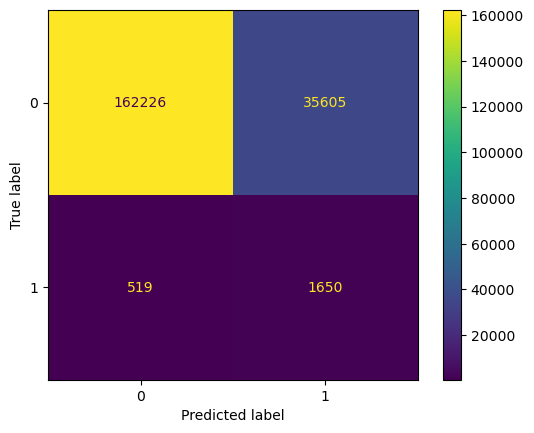

In [ ]:
y_prob = best_logreg_model.predict_proba(X_validation)[:, 1]
y_pred = y_prob> target_thresh_dict['LogReg']

cm = confusion_matrix(y_validation, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### CM for XGB

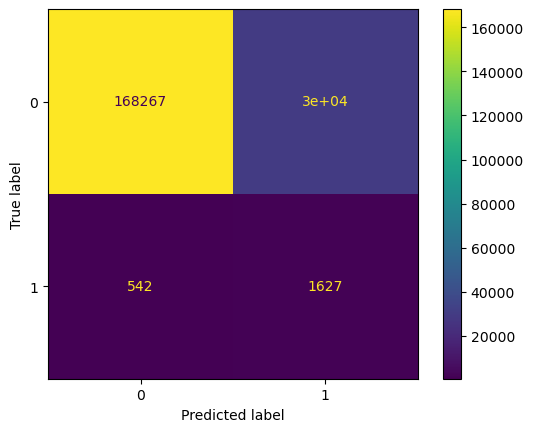

In [300]:
y_prob = best_xgb_model.predict_proba(X_validation)[:, 1]
y_pred = y_prob> target_thresh_dict['XGB']

cm = confusion_matrix(y_validation, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### CM for LGBM

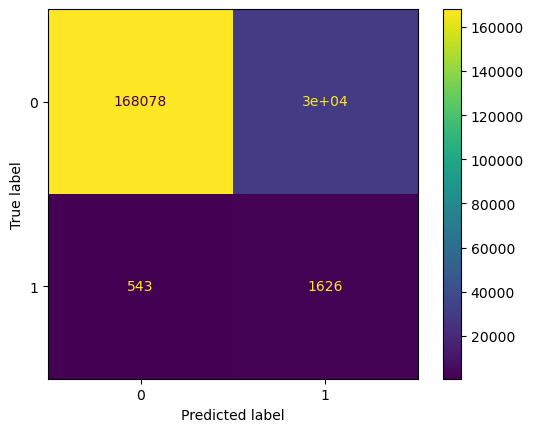

In [301]:
y_prob = best_lgbm_model.predict_proba(X_validation)[:, 1]
y_pred = y_prob> target_thresh_dict['lgbm']

cm = confusion_matrix(y_validation, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Summary

After tunning the models they all behave functionally the same. Generally they have a FN rate of around 1/4, probably the limit of what we can do with this data. 

# Production Exports
We have finished training and validating our models. The final 3 perform functionally the same, I am going to continue with just logreg model. Need the below exports to containerize and turn into API 

In [359]:
schema_names = best_logreg_model.named_steps['pre'].feature_names_in_.tolist()
schema_dtypes= df[schema_names].dtypes.to_dict()

schema = {}

for colname, type in schema_dtypes.items(): 
    if type == 'category': 
        schema[colname] = str(schema_dtypes[colname].categories.tolist())
    else:
        schema[colname] = str(type)


threshold = {
    'threshold' : target_thresh_dict['LogReg']
}

with open("deploy/artifacts/feature_schema.json", "w") as f:
    json.dump(schema, f, indent=2)

with open("deploy/artifacts/threshold.json", "w") as f:
    json.dump(threshold, f, indent=2)

joblib.dump(best_logreg_model, "deploy/artifacts/fraud_model.pkl")

['deploy/artifacts/fraud_model.pkl']

Save and export enviroments

In [326]:
!conda env export --no-builds > environment.yml
!conda list -e >  deploy/requirements.txt